In [ ]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


- Still need to understand why the mean value reduce with years
- Understand pick NaN values around Christmas 2023

In [2]:
sys.path.append(str(Path("Alpiq ETHdatathon challenge 2025").resolve()))
from data import DataLoader, SimpleEncoding
input_path = "Alpiq ETHdatathon challenge 2025/datasets2025/"
loader = DataLoader(input_path)
consumptions, features, example_solution = loader.load_data("IT")

In [3]:
from src.preprocessing import PreProcessClass
preprocessor_it = PreProcessClass(consumptions, features)

# Pick all customer columns
col_customers = [id for id in consumptions.columns if id.startswith("VALUEMWHMETERINGDATA_customerIT")]
data = preprocessor_it.preprocess_nonan(col_customers)

In [4]:
def plot_basic(df, col, title):
    """
    Plots a time series line chart using Plotly.
    """

    fig = px.line(
        df,
        x=df.index,     # Time on x-axis
        y=col,          # Column to plot
        title=title,
        height=500,
        width=1000,
        labels={col: 'Value', 'index': 'Time'}
    )

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Value",
    )

    fig.show()

def plot_aggregated_consumption(df, group_by, title):
    """
    Function to plot the aggregated consumption data.
    """
    agg_df = df.groupby(group_by, as_index=False, observed = True).agg({'MeanConsumption': 'mean'})
    
    if group_by[1] == "Dow":
        # Order the days of the week
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        agg_df['Dow'] = pd.Categorical(agg_df['Dow'], categories=day_order, ordered=True)
        agg_df = agg_df.sort_values(['Dow', group_by[0]])

    # Plot
    fig = px.line(
        agg_df,
        x=group_by[0],
        y='MeanConsumption',
        title=title,
        color = group_by[1] if len(group_by) > 1 else None,
        height=500,
        width=1000,
    )

    fig.update_layout(
        xaxis_title=group_by[0],
        yaxis_title='Mean Energy Demand [MW]',
        legend_title=group_by[1] if len(group_by) > 1 else None
    )
    
    fig.show()

def plot_weekend_segments(data: pd.DataFrame, value_col: str, flag_col: str, title: str):
    """
    Plot a time series with colored segments for changes in a boolean flag,
    without creating a flag_change column.
    """

    df = data[[value_col, flag_col]].dropna().copy()
    df.index = pd.to_datetime(df.index)

    colors = {True: "red", False: "blue"}
    labels = {True: "Weekend", False: "Weekday"}
    plotted = set()

    fig = go.Figure()
    start_idx = 0
    current_flag = df[flag_col].iloc[0]

    for i in range(1, len(df)):
        if df[flag_col].iloc[i] != current_flag:
            segment = df.iloc[start_idx:i]
            fig.add_trace(go.Scatter(
                x=segment.index,
                y=segment[value_col],
                mode='lines',
                line=dict(color=colors[current_flag]),
                name=labels[current_flag] if current_flag not in plotted else None,
                showlegend=current_flag not in plotted
            ))
            plotted.add(current_flag)
            start_idx = i
            current_flag = df[flag_col].iloc[i]

    # Add the final segment
    segment = df.iloc[start_idx:]
    fig.add_trace(go.Scatter(
        x=segment.index,
        y=segment[value_col],
        mode='lines',
        line=dict(color=colors[current_flag]),
        name=labels[current_flag] if current_flag not in plotted else None,
        showlegend=current_flag not in plotted
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title=value_col,
        height=500,
        width=1000
    )

    fig.show()


# EDA

### **New Features**

Part 1:

- **ActivePartDay**: (6am-8pm)
- **IsWeekendSpecial**: Saturday 8pm to Monday 6 am
  
Part 2:

-----

### Part 1:

In [5]:
plot_basic(data,"temp","Temperature over time")

### 

There is an increase of customers over the years, which imply a decrease value of missing value over time.

In [6]:
missing_data = data.isna().sum(axis=1).to_frame(name = "Missing Values")
plot_basic(missing_data,"Missing Values","Missing Values Over Time")

### Check **Day|Year|Season|Month** effect w.r.t Hour

- We see the demand is higher on the weekend and during the active part of the day (6am-8pm).

In [7]:
data["MeanConsumption"] = data[col_customers].mean(axis=1)
df = data.drop(columns = col_customers)

dow_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df["Dow"] = df["Dow"].map(dow_map)

df.head()

spv  temp  Hour  Day  Month  Year       Dow  DayYear  \
2022-01-01 00:00:00  0.0   3.9     0    1      1  2022  Saturday        1   
2022-01-01 01:00:00  0.0   3.7     1    1      1  2022  Saturday        1   
2022-01-01 02:00:00  0.0   3.4     2    1      1  2022  Saturday        1   
2022-01-01 03:00:00  0.0   3.4     3    1      1  2022  Saturday        1   
2022-01-01 04:00:00  0.0   3.6     4    1      1  2022  Saturday        1   

                     Week  Season  IsWeekend  IsWeekendSpecial  ActiveDay  \
2022-01-01 00:00:00    52       1          1                 0          0   
2022-01-01 01:00:00    52       1          1                 0          0   
2022-01-01 02:00:00    52       1          1                 0          0   
2022-01-01 03:00:00    52       1          1                 0          0   
2022-01-01 04:00:00    52       1          1                 0          0   

                     MeanConsumption  
2022-01-01 00:00:00         0.086554  
2022-01-01 01:00:00         0.085355  
2022-01-01 02:00:00         0.085400  
2022-01-01 03:00:00         0.086178  
2022-01-01 04:00:00         0.089089

In [8]:
plot_aggregated_consumption(df, ["Hour", "Dow"], "Mean Energy Demand by Hour and Day of Week")

In [9]:
plot_aggregated_consumption(df, ['Hour', 'Season'], 'Mean Hourly Power Demand per Season')

In [10]:
plot_aggregated_consumption(df, ['Hour','Year'], 'Mean Hourly Power Demand per Year')

In [11]:
plot_aggregated_consumption(df, ['Hour','Month'], 'Mean Hourly Power Demand per Month')

### Part 2:

In [12]:
plot_weekend_segments(
    data=data,
    value_col="VALUEMWHMETERINGDATA_customerIT_1",
    flag_col="IsWeekend",
    title="Customer 1 - Weekend vs Weekday Segmented Plot"
)


**Check Difference values of customers over every weekend**

In [15]:
data_2023 = data.loc["2023-01-01":"2023-12-31"]

df_2023_weekend = data_2023[data_2023["IsWeekendSpecial"] == True ]
df_2023_week = data_2023[data_2023["IsWeekendSpecial"] == False ]
df_2023_night = data_2023[data_2023["ActiveDay"] == False ]

WeeklyWeekend_means = (df_2023_weekend
                .groupby(["Week", "IsWeekendSpecial"])[col_customers]
                .mean()
                .reset_index()
                )
WeeklyWeek_means = (df_2023_week
                .groupby(["Week", "IsWeekendSpecial"])[col_customers]
                .mean()
                .reset_index()
                )

WeeklyNight_means = (df_2023_night
                .groupby(["Week", "ActiveDay"])[col_customers]
                .mean()
                .reset_index()
                )


WeeklyWeekend_means = WeeklyWeekend_means.set_index("Week")
WeeklyWeek_means = WeeklyWeek_means.set_index("Week")
WeeklyNight_means = WeeklyNight_means.set_index("Week")

weekend_long = WeeklyWeekend_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
weekend_long["Period"] = "Weekend"

week_long = WeeklyWeek_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
week_long["Period"] = "Week"

night_long = WeeklyNight_means.reset_index().melt(id_vars="Week", var_name="Customer", value_name="MeanConsumption")
night_long["Period"] = "Night"

# Step 2: Concatenate
combined_df = pd.concat([weekend_long, week_long, night_long], ignore_index=True)

# Step 2: Concatenate
combined_df = pd.concat([weekend_long, week_long, night_long], ignore_index=True)

unique_customers = combined_df["Customer"].unique()
customer_map = {col: f"Customer {i+1}" for i, col in enumerate(unique_customers)}
combined_df["CustomerName"] = combined_df["Customer"].map(customer_map)



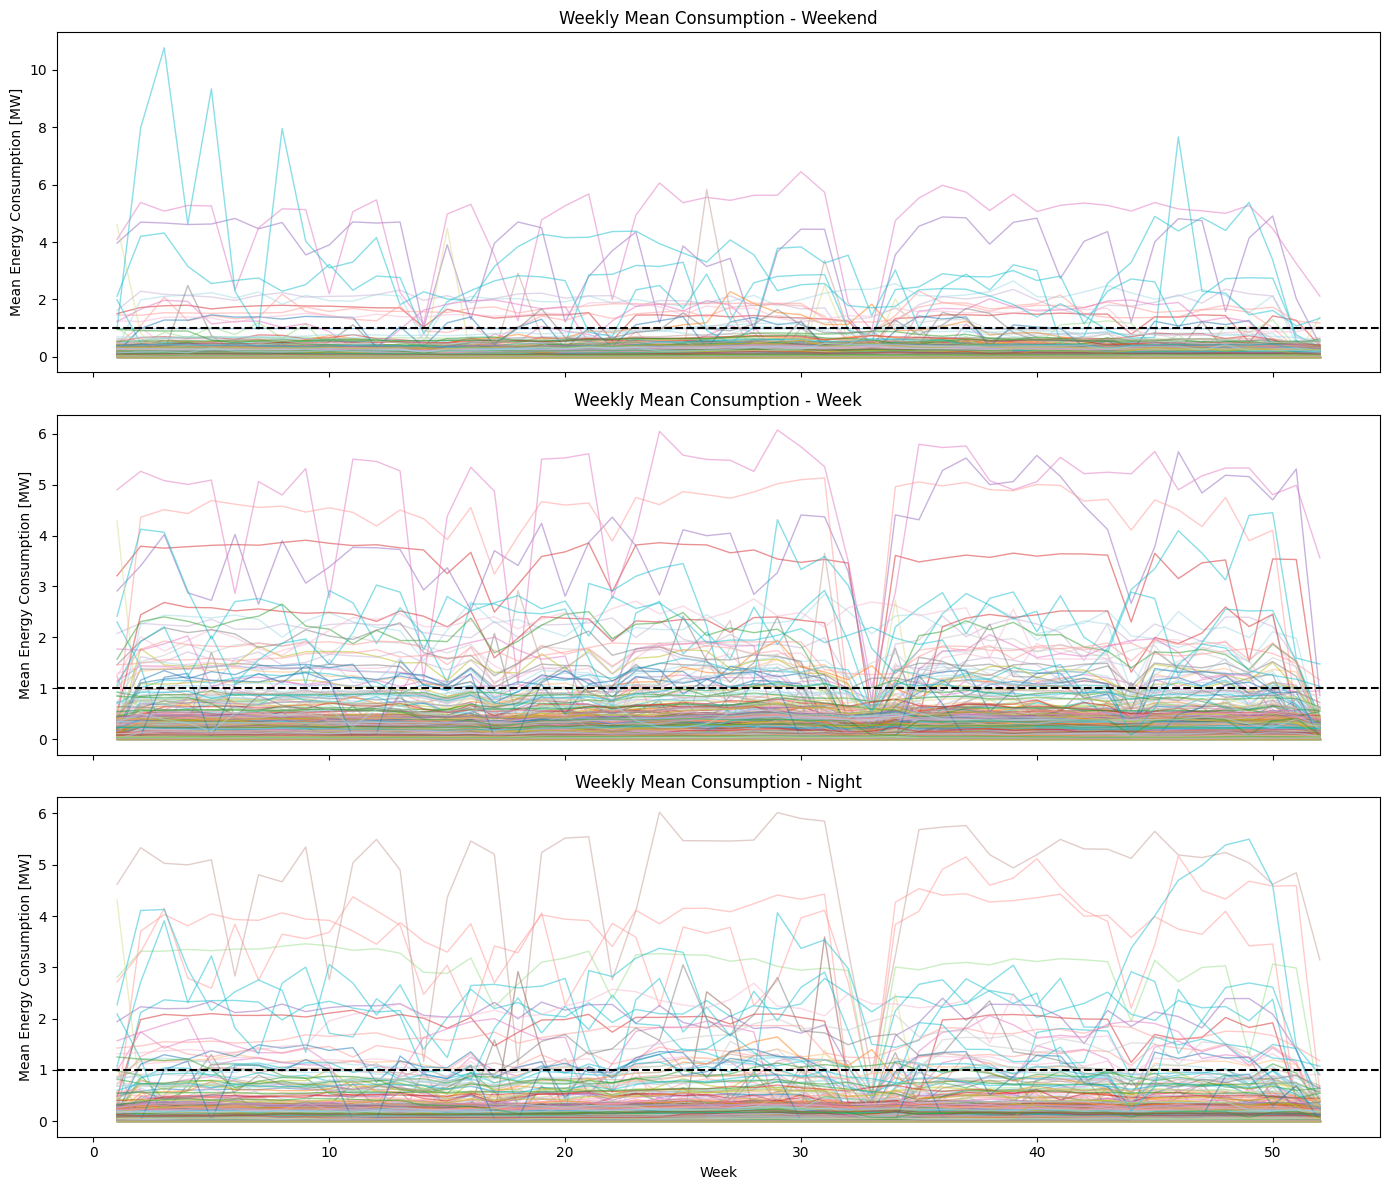

In [17]:
# Loop through periods and plot subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

periods = ["Weekend", "Week", "Night"]
colors = plt.cm.tab20.colors  # for more distinguishable lines

for i, period in enumerate(periods):
    subset = combined_df[combined_df["Period"] == period]
    for j, (customer, group) in enumerate(subset.groupby("CustomerName")):
        axs[i].plot(group["Week"], group["MeanConsumption"], label=customer, color=colors[j % len(colors)], alpha=0.5, linewidth=1)

    axs[i].axhline(y=1, color="black", linestyle="--", label="Threshold")
    axs[i].set_title(f"Weekly Mean Consumption - {period}")
    axs[i].set_ylabel("Mean Energy Consumption [MW]")

axs[-1].set_xlabel("Week")
plt.tight_layout()
plt.show()


In [30]:
customer_active_weekend = []
customer_active_week = []
customer_active_night = []

for col in enumerate(col_customers):
    if WeeklyWeekend_means[col[1]].mean() >= 1:
        customer_active_weekend.append(col[1])
    if WeeklyWeek_means[col[1]].mean() >= 1:
        customer_active_week.append(col[1])
    if WeeklyNight_means[col[1]].mean() >= 1:
        customer_active_night.append(col[1])

special_customers = list(set(customer_active_weekend + customer_active_week + customer_active_night))

print(f"There is {len(special_customers)} special customers in the period 2023")

There is 31 special customers in the period 2023


----------

### Auto-Correlogram
**Auto-Correlogram**: Check the correlation of the data with itself at different lags. This will help us understand the seasonality and trend in the data. We can use the `plot_acf` function from the `statsmodels` library to plot the auto-correlogram.

## Forecasting Models

### Triple Exponential Smoothing: Holt-Winter's

### Explicit Multi-Seasonality: Prophet
